In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from scipy import ndimage
%matplotlib inline

Считаем изображение и получим преобразованное в серые оттенки

Так же у нас изображение считалось в формате RGB преобразуем его в формат библиотеки openCV

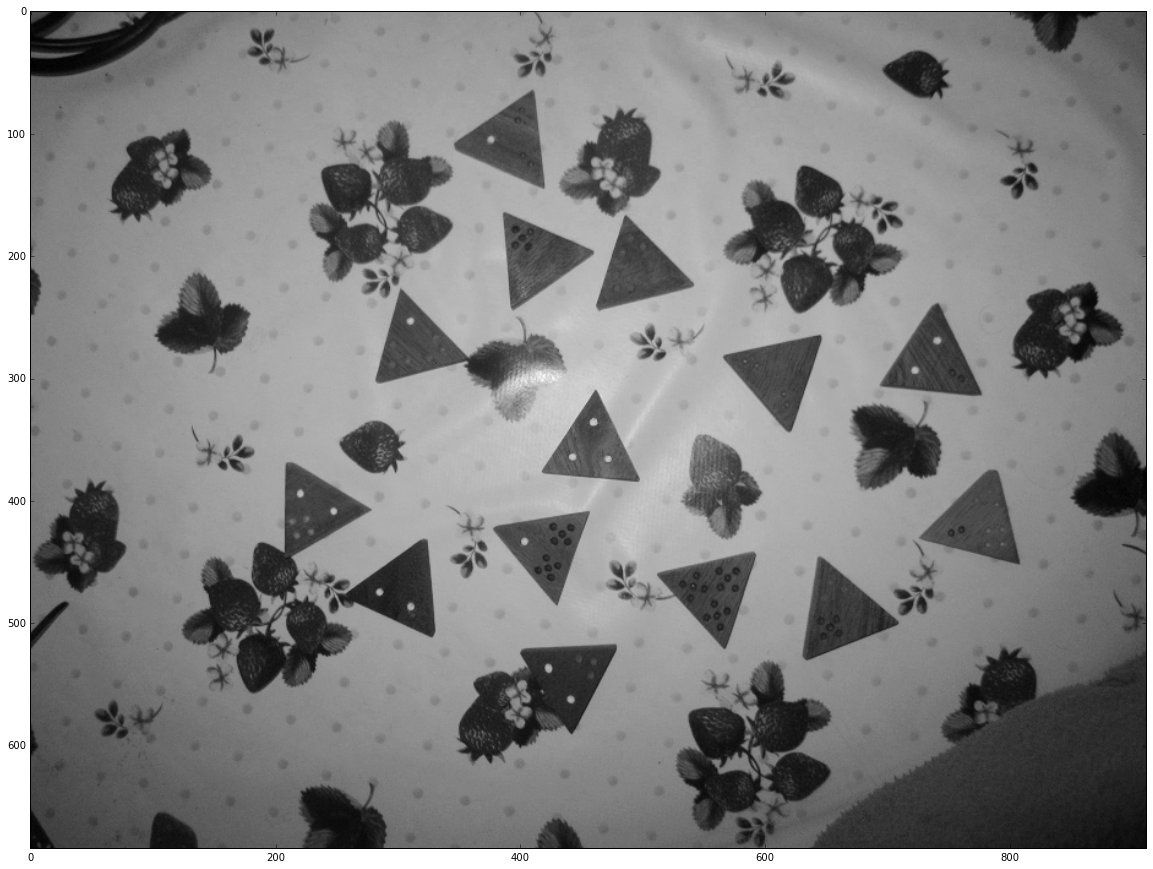

In [2]:
image = cv2.imread('./train/Pict_4_2.bmp', 1)
opencv_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 30))
plt.imshow(gray, cmap='gray')

In [3]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
 
    return cv2.LUT(image, table)

Применим гамма-коррекцию для лучшего нахожедения границ треугольников.

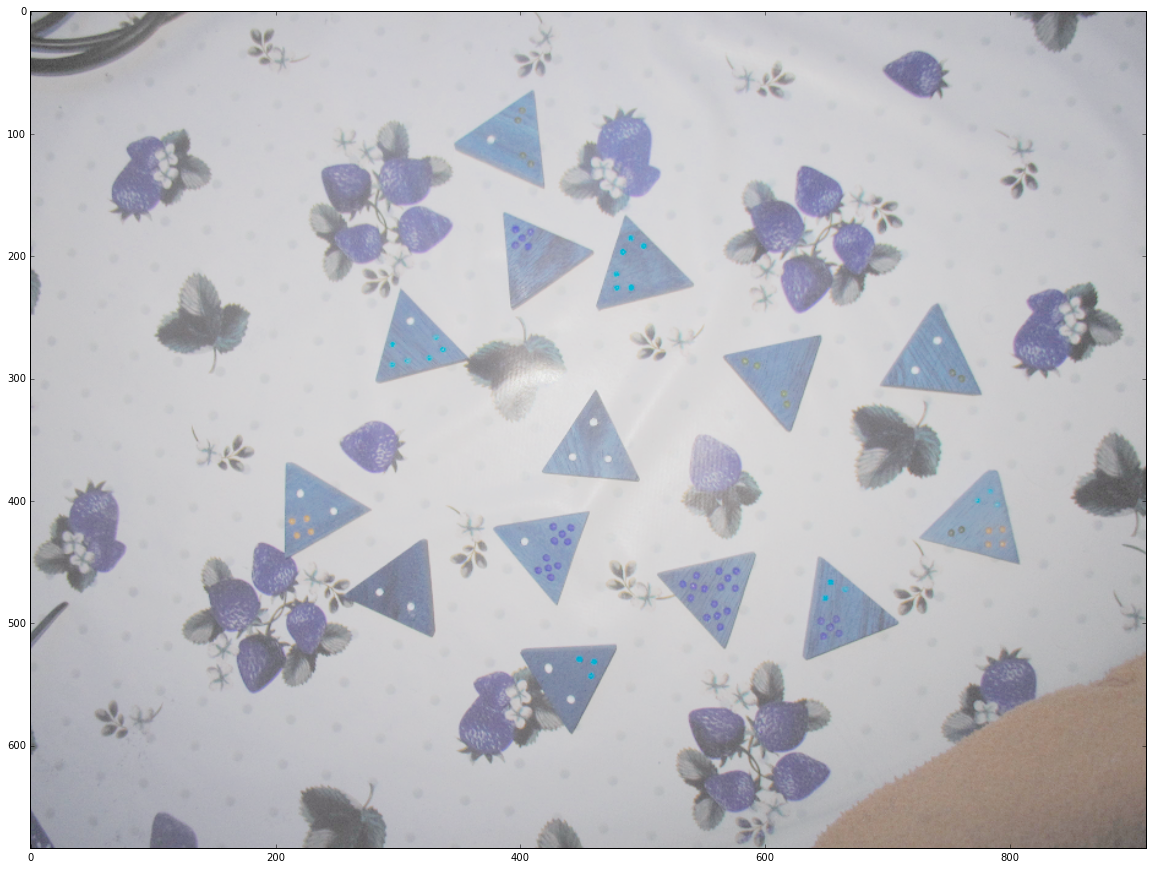

In [4]:
adjusted_img = adjust_gamma(image, 3)
gray = cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 30))
plt.imshow(adjusted_img, cmap='gray')

Применим медианный фильтр, чтобы точки на фишках не мешали

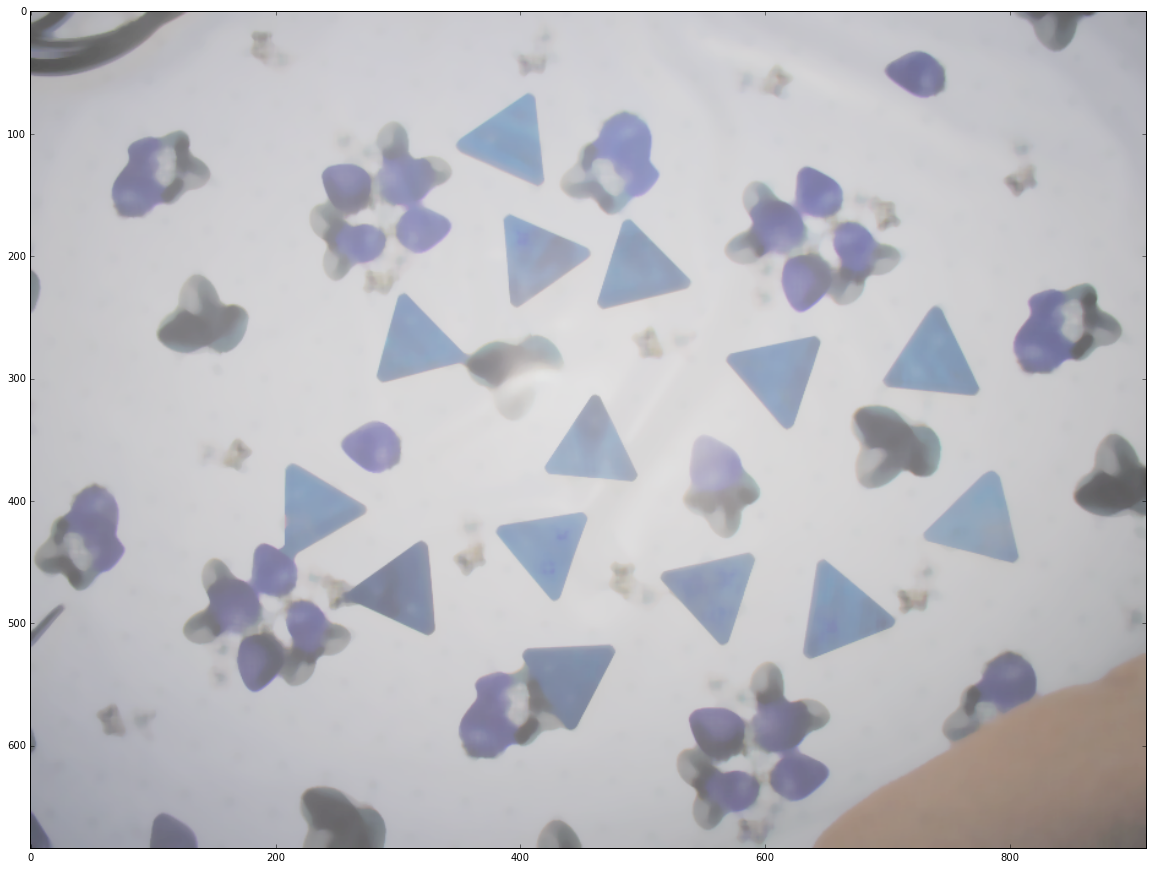

In [5]:
without_points = cv2.medianBlur(adjusted_img, 11)

plt.figure(figsize=(20, 30))
plt.imshow(without_points)

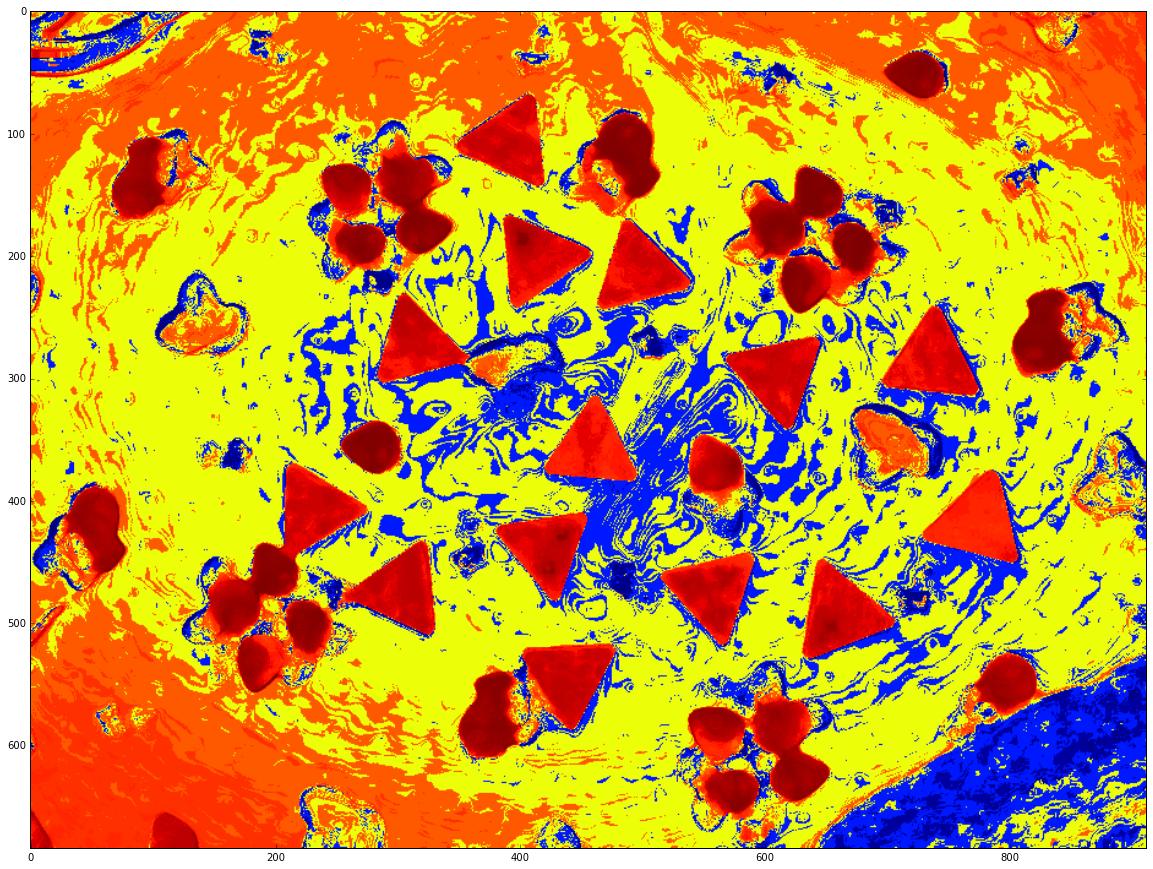

In [6]:
lab = cv2.cvtColor(without_points, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
eq_a = cv2.equalizeHist(a)

plt.figure(figsize=(20, 30))
plt.imshow(eq_a)

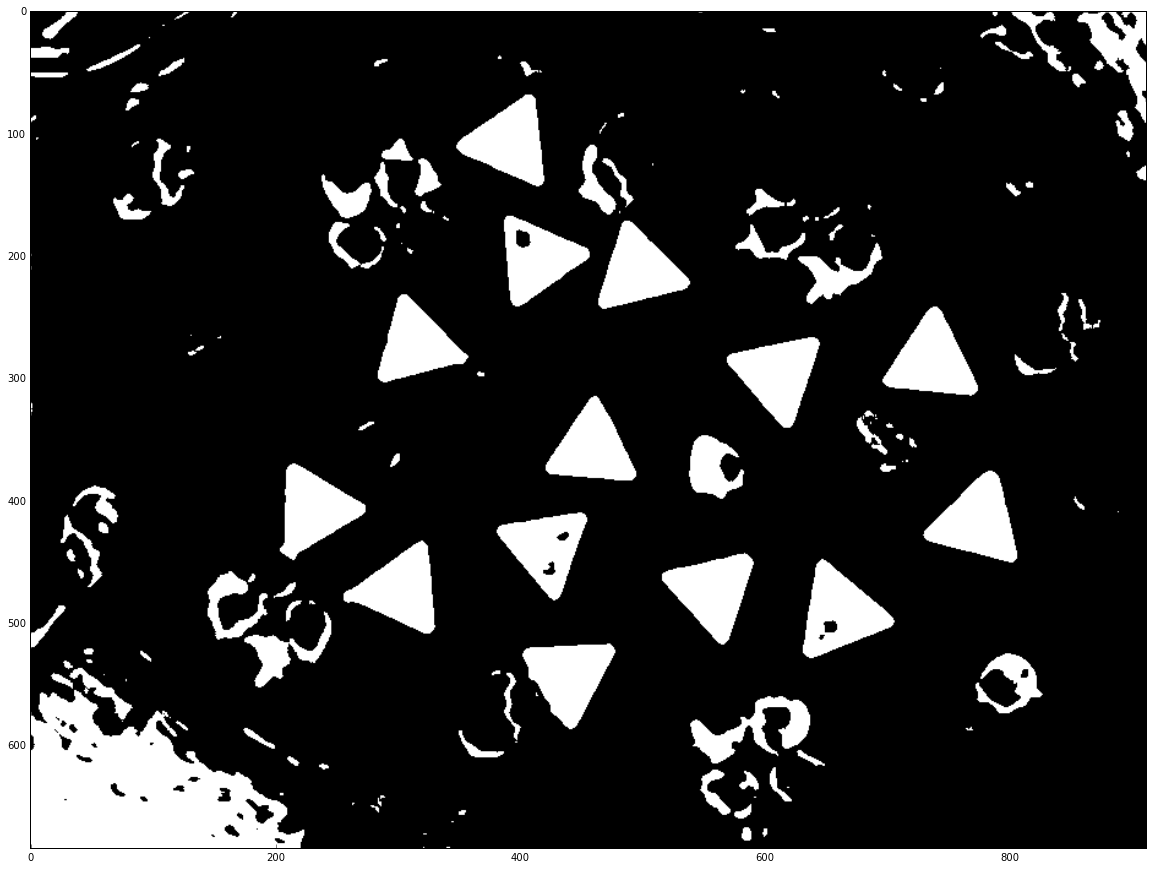

In [7]:
straw_mask = cv2.inRange(eq_a, 210, 245)
straw_mask = cv2.medianBlur(straw_mask, 5)
plt.figure(figsize=(20, 30))
plt.imshow(straw_mask, cmap='gray')

In [8]:
hsv_final = cv2.cvtColor(without_points, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_final)

Получаем карту границ по каналу V 

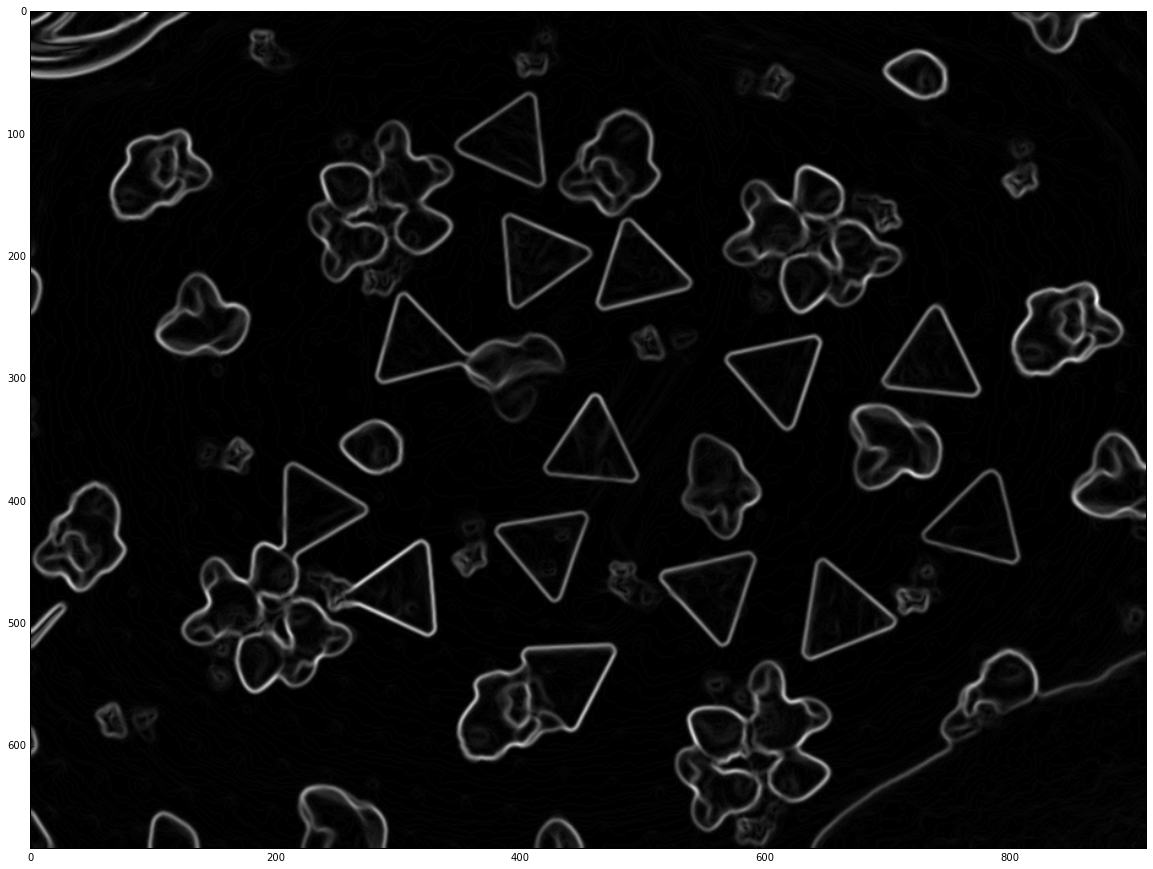

In [9]:
blurred = cv2.GaussianBlur(l, (5, 5), 0)
sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=1)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=1)
v_image = (sobelx**2 + sobely**2)**(1/2)
v_image = cv2.convertScaleAbs(v_image)

plt.figure(figsize=(20, 30))
plt.imshow(v_image, cmap='gray')

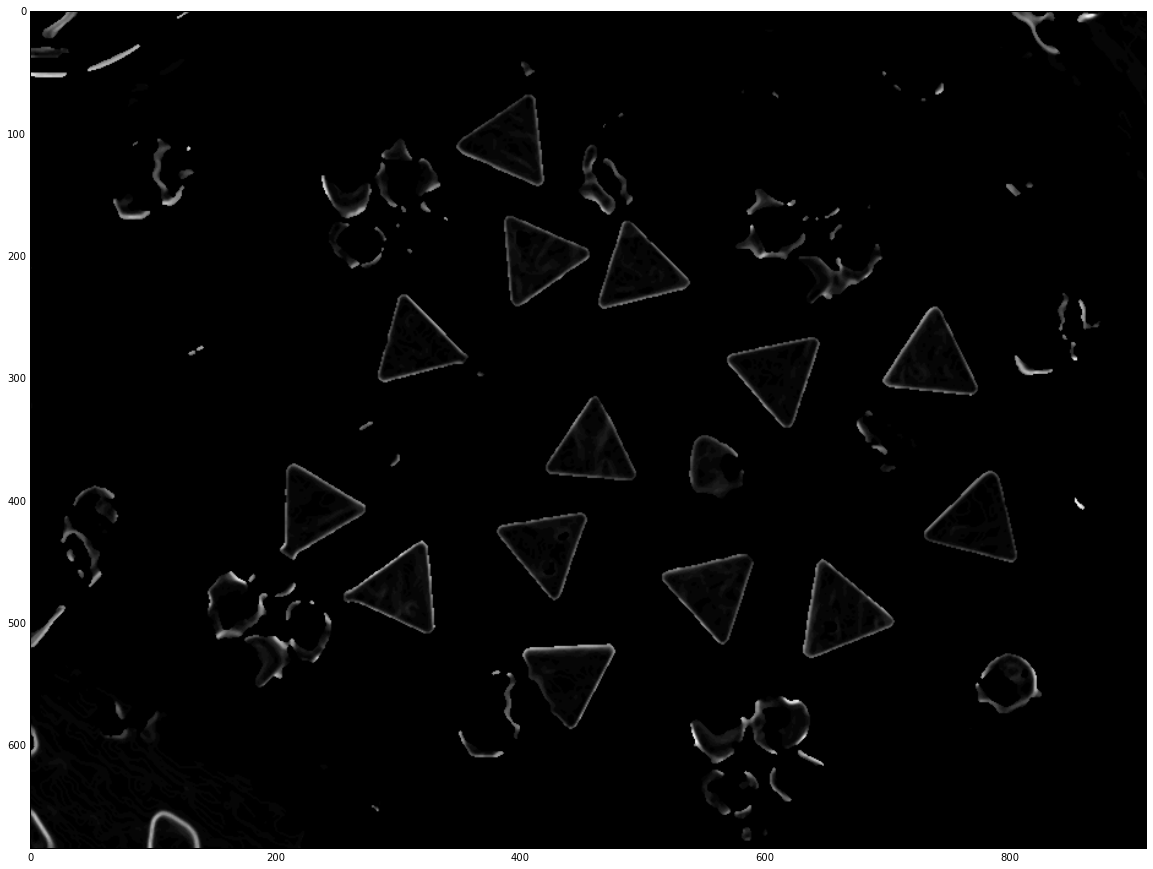

In [10]:
thresh = v_image & straw_mask
median_thresh = cv2.medianBlur(thresh, 3)
plt.figure(figsize=(20, 30))
plt.imshow(median_thresh, cmap='gray')

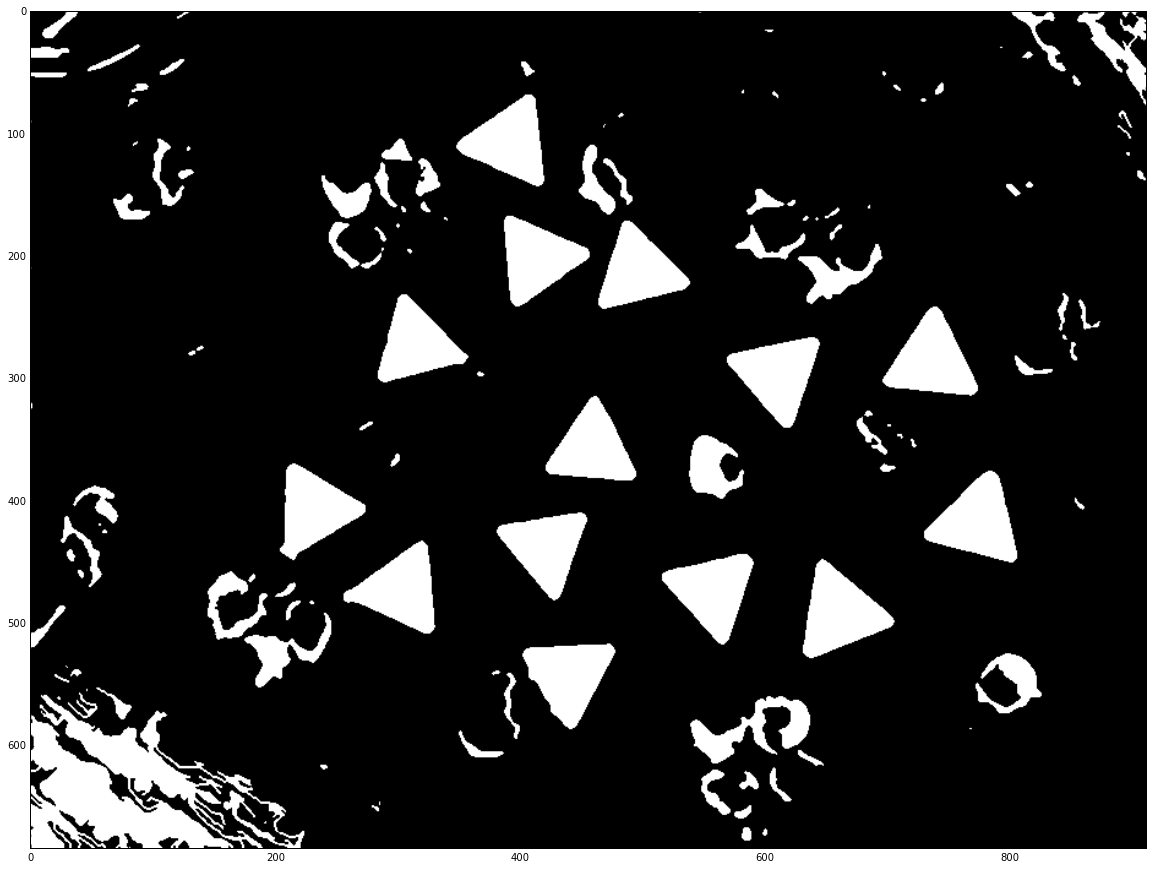

In [11]:
filled = ndimage.binary_fill_holes(median_thresh).astype(int)
filled = cv2.convertScaleAbs(filled)

plt.figure(figsize=(20, 30))
plt.imshow(filled, cmap='gray')

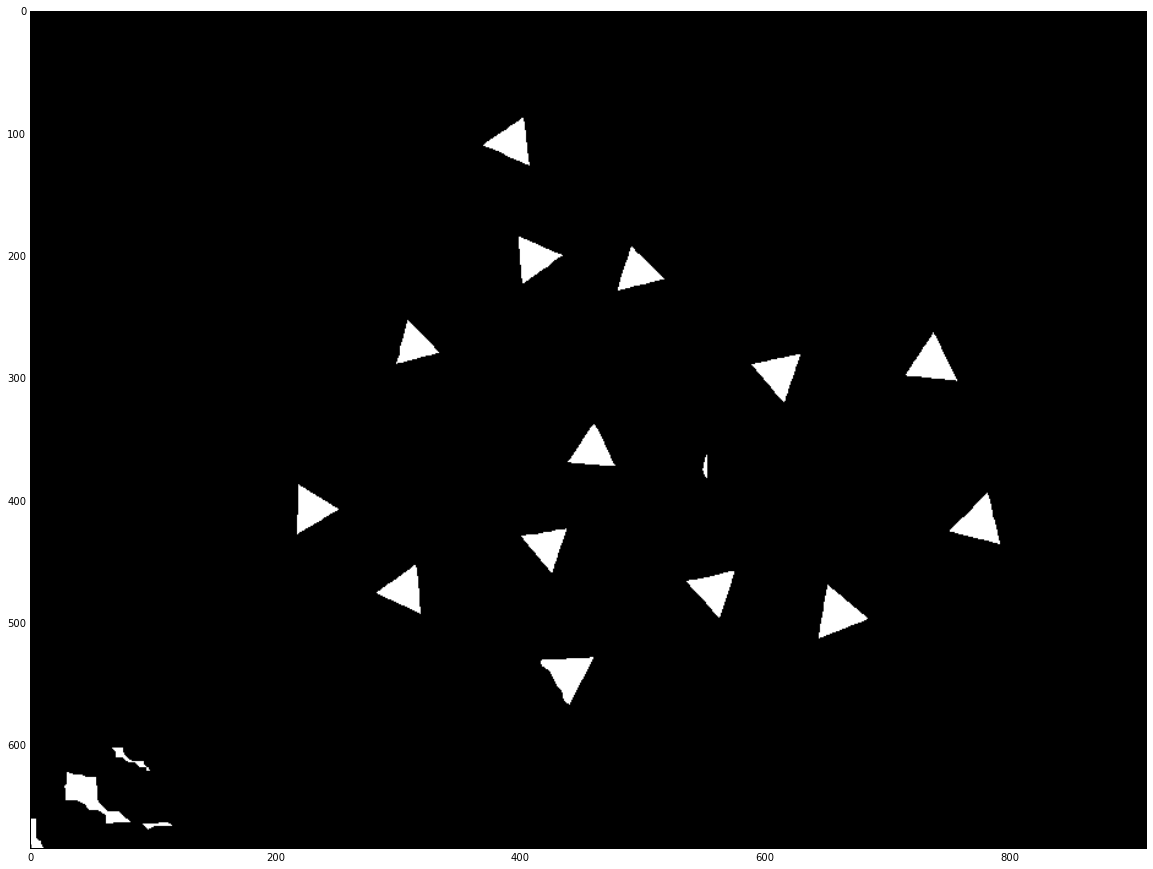

In [12]:
blurred = cv2.medianBlur(filled, 5)
kernel = np.ones((5, 5),np.uint8)
erode_first = cv2.erode(blurred, kernel, iterations = 5)

plt.figure(figsize=(20, 30))
plt.imshow(erode_first, cmap='gray')

Функция для нахождения медианного значения площади треугоьников(нужна для отсеивания лишних элементов фона)

In [13]:
def area_for_triangles(cnts, phase):
    area = 0
    count = 0
    for c in cnts:
        hull = cv2.convexHull(np.array(c))
        peri = cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, 0.1*peri, True)  
        if (phase == 1):
            area += cv2.contourArea(hull)
            count += 1
        elif len(approx) == 3:
            area += cv2.contourArea(hull)
            count += 1
    
    area /= count
    return area

In [14]:
def filtering(image, coeff):
    black = image.copy()
    black[:,:] = 0

    contours = cv2.convertScaleAbs(image)

    cnts = cv2.findContours(contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    area = area_for_triangles(cnts, 0)
    for c in cnts:    
        hull = cv2.convexHull(np.array(c))    
        peri = cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, 0.1*peri, True)        
        if cv2.contourArea(hull) - area < -area*coeff or len(approx) != 3 or abs(cv2.contourArea(hull)-cv2.contourArea(c)) > 0.4*cv2.contourArea(c):
            continue    
        cv2.drawContours(black, [c], -1, (255, 255, 255), 2)
    filled = ndimage.binary_fill_holes(black).astype(int)
    filled = cv2.convertScaleAbs(filled)
    return filled

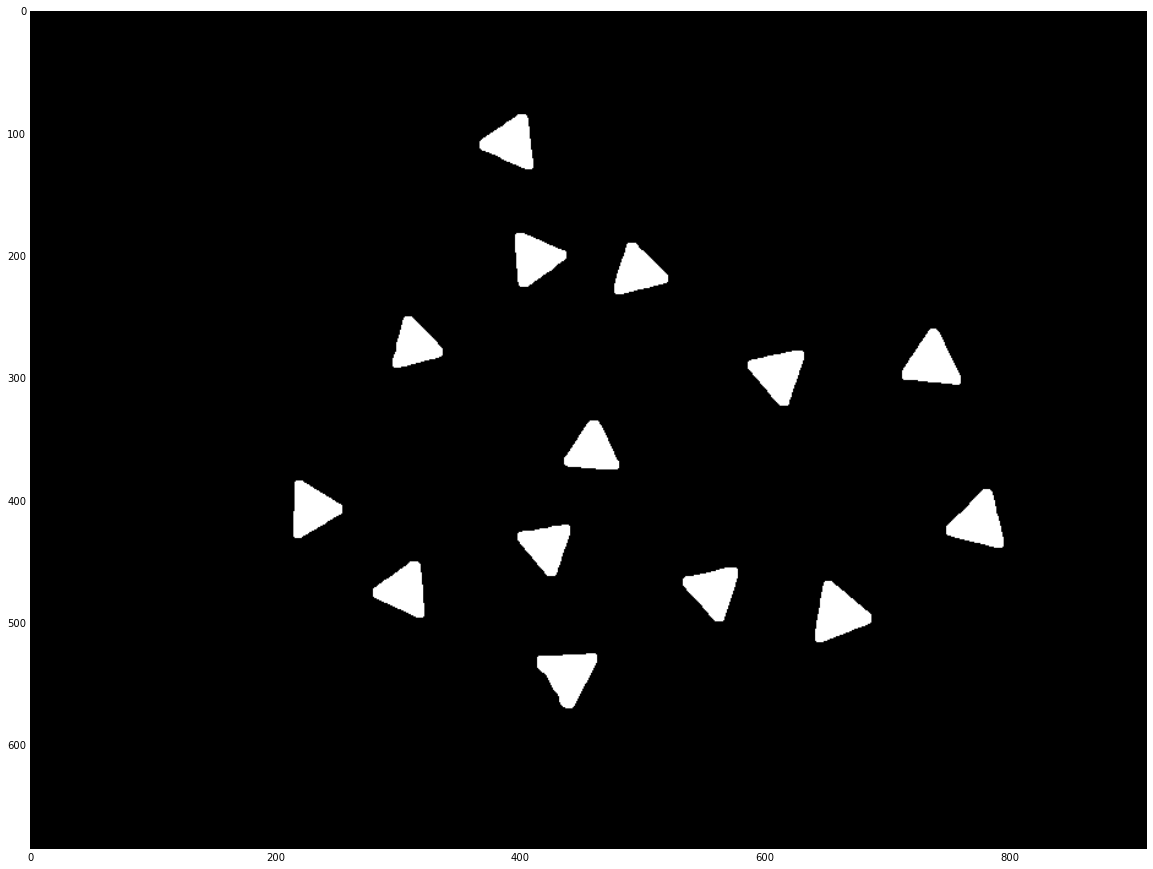

In [15]:
filtered = filtering(erode_first, 1.5)
filtered = filtering(filtered, 0.8)
filtered = filtering(filtered, 0.5)
plt.figure(figsize=(20, 30))
plt.imshow(filtered, cmap='gray')

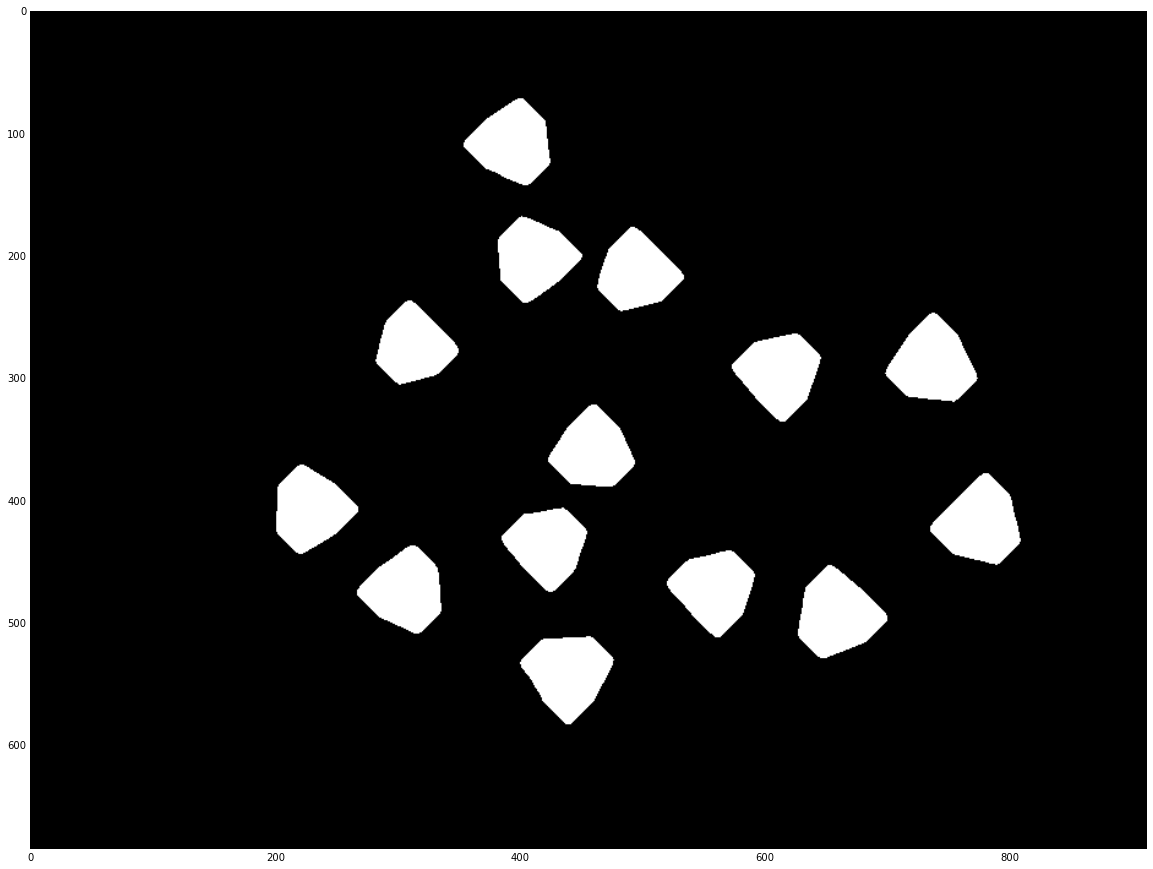

In [16]:
kernel = np.array([[0, 0, 1, 0, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 0, 1, 0, 0]])
kernel = cv2.convertScaleAbs(kernel)
blurred = cv2.medianBlur(filtered, 11)

dilate_first = cv2.dilate(blurred, kernel, iterations = 7)
plt.figure(figsize=(20, 30))
plt.imshow(dilate_first, cmap='gray')

Ищем точки на треугольниках

In [17]:
def dist(a, b):
    cur = 0
    for i in range(len(a)):
        cur += (a[i] - b[i])**2
    return cur

In [18]:
def numbers(fine_contours, number):
    if fine_contours == 0:
        return None
    count = fine_contours / number
    if fine_contours % number >= int(number/2) and number != 1:
        count += 1
    count = int(count)
    list_to_return = []
    for i in range(count):
        list_to_return.append(number)
    return list_to_return

In [19]:
def identify_color(image, center, radius):
    colors = [(80, 60, 60), (40, 70, 45), (130, 130, 130), (160, 160, 160), (30, 40, 40), (100, 70, 50)]    
    b, g, r = cv2.split(image)
    black = r.copy()
    black[:, :] = 0
    cv2.circle(black, center, radius, (255,255,255), thickness=cv2.FILLED)
    mean_r = cv2.mean(r, mask=black)
    mean_g = cv2.mean(g, mask=black)
    mean_b = cv2.mean(b, mask=black)
    
    mean_color = (mean_r[0], mean_g[0], mean_b[0])
    min_ind = -1
    min_dist = np.inf
    for i in range(len(colors)):
        distance = dist(colors[i], mean_color)
        if (distance < min_dist):
            min_dist = distance
            min_ind = i
    if min_dist > 1000:
        return -1
    if min_ind == 3:
        min_ind = 2
    if min_ind == 4:
        min_ind = 1
    if min_ind == 5:
        min_ind = 0
    return min_ind


In [20]:
def find_for_channel(image, color_img, thresh_1, thresh_2, 
                     white, blur_coeff, erosion, not_mask, 
                     more_than_one, number = 0, big_radius=17):    
    supporting_image = color_img.copy()
    mask = cv2.threshold(image, thresh_1, thresh_2, cv2.THRESH_BINARY)[1]
    if not_mask:
        mask = ~mask
    kernel = np.ones((5, 5),np.uint8)
    
    blurred = cv2.medianBlur(mask, blur_coeff)
    
    if white:
        closed_erode = cv2.erode(blurred, kernel, iterations = erosion)
        closed_erode = cv2.dilate(closed_erode, kernel, iterations = erosion)
    else:
        closed_erode = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations = erosion)
    
    contours = cv2.convertScaleAbs(closed_erode)

    cnts = cv2.findContours(contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    fine_contours = np.array([0, 0, 0, 0])
    
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    get_number = np.array([4, 2, 1, number])
    for c in cnts:
        hull = cv2.convexHull(np.array(c))
        
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x), int(y))
        radius = int(radius)
        area = cv2.contourArea(c)
        size = 35
        if (radius < 6) or (radius > big_radius) or (area < 3.14*radius**2*0.6) or x < size or y < size \
            or x > 300-size or y > 300-size:
            continue
        cv2.circle(color_img, center, radius, (0,255,0), thickness=2)
        
        if more_than_one:
            color = identify_color(supporting_image.copy(), center, radius)
            if color == -1:
                continue
            fine_contours[color] += 1
        else:
            fine_contours[3] += 1
    
    list_to_return = np.array([])
    
    for i in range(len(fine_contours)):
        cur_list = numbers(fine_contours[i], get_number[i])
        if cur_list != None:
            list_to_return = np.append(list_to_return, np.array(cur_list))
    return list_to_return

In [21]:
from skimage.filters import gaussian
from skimage import img_as_float

In [22]:
def find_points(cimg, light, l_channel):    
    big_color_image = cv2.resize(cimg, (300, 300), interpolation = cv2.INTER_CUBIC)    
    l_channel = cv2.resize(l_channel, (300, 300), interpolation = cv2.INTER_CUBIC)  
    adjusted_img = adjust_gamma(big_color_image, 2.5)
    numbers = np.array([])  
    if light:
        lab = cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab)
        numbers = np.append(numbers, find_for_channel(b, big_color_image, thresh_1=123, thresh_2=255, 
                                                      white=1, blur_coeff=13, erosion=3, not_mask=0, 
                                                      more_than_one=0, number=4)) 
        
        numbers = np.append(numbers, find_for_channel(a, big_color_image, thresh_1=140, thresh_2=255, 
                                                      white=1, blur_coeff=7, erosion=2, not_mask=0, 
                                                      more_than_one=0, number=5)) 

        lab = cv2.cvtColor(adjusted_img, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)

        numbers = np.append(numbers, find_for_channel(b, big_color_image, thresh_1=160, thresh_2=255, 
                                                      white=1, blur_coeff=7, erosion=2, not_mask=0, 
                                                      more_than_one=0, number=3)) 

        numbers = np.append(numbers, find_for_channel(l_channel, big_color_image, thresh_1=100, thresh_2=255, 
                                                      white=0, blur_coeff=7, erosion=2, not_mask=0, 
                                                      more_than_one=0, number=1, big_radius=9)) 
        hls = cv2.cvtColor(adjusted_img, cv2.COLOR_RGB2HLS)
        h, l, s = cv2.split(hls)
        numbers = np.append(numbers, find_for_channel(s, big_color_image, thresh_1=25, thresh_2=255, 
                                                      white=0, blur_coeff=15, erosion=3, not_mask=0, 
                                                      more_than_one=0, number=2)) 
    else:        
        lab = cv2.cvtColor(adjusted_img, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        numbers = np.append(numbers, find_for_channel(b, big_color_image, thresh_1=158, thresh_2=255, 
                                                      white=1, blur_coeff=7, erosion=2, not_mask=0, 
                                                      more_than_one=0, number=3)) 
        lab = cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab)
        numbers = np.append(numbers, find_for_channel(a, big_color_image, thresh_1=138, thresh_2=255, 
                                                      white=1, blur_coeff=7, erosion=2, not_mask=0, 
                                                      more_than_one=0, number=5)) 
        numbers = np.append(numbers, find_for_channel(b, big_color_image, thresh_1=121, thresh_2=255, 
                                                      white=1, blur_coeff=13, erosion=3, not_mask=0, 
                                                      more_than_one=1, number=0)) 



    numbers = np.append(numbers, [0, 0, 0])
    
    ans = ''
    for i in range(3):
        ans += str(int(numbers[i])) 
        ans += ' '
    
    return ans

Отсеиваем оставшиеся элементы фона

center =  (438, 541) ans =  3 1 1 
center =  (658, 492) ans =  3 5 0 
center =  (557, 472) ans =  5 5 5 
center =  (305, 473) ans =  1 1 0 
center =  (421, 436) ans =  5 5 1 
center =  (774, 418) ans =  3 4 2 
center =  (228, 407) ans =  4 1 1 
center =  (458, 359) ans =  1 1 1 
center =  (611, 295) ans =  2 2 0 
center =  (736, 287) ans =  2 1 1 
center =  (312, 273) ans =  3 3 1 
center =  (495, 213) ans =  3 3 0 
center =  (411, 202) ans =  5 0 0 
center =  (393, 108) ans =  2 2 1 


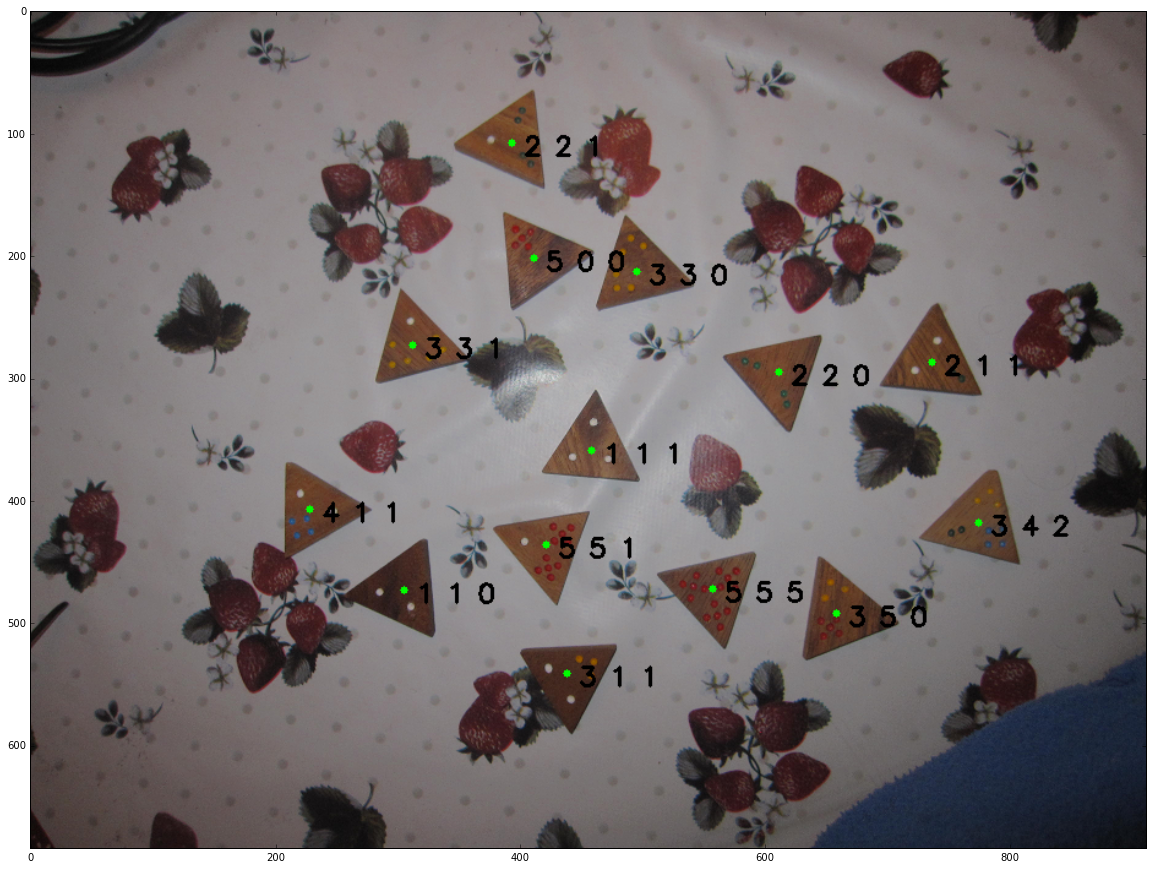

In [24]:
contours = cv2.convertScaleAbs(dilate_first)

cnts = cv2.findContours(contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

contours_image = opencv_image.copy()

mean_color = cv2.mean(opencv_image)
dist_to_zero = dist(mean_color, (100, 100, 100, 0))
if dist_to_zero > 1500:
    light = True
else:
    light = False

area = area_for_triangles(cnts, 1)
for c in cnts:
    hull = cv2.convexHull(np.array(c))    
    peri = cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, 0.1*peri, True)        
    
    r = cv2.boundingRect(hull)
    sub_image = contours_image[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
    lab = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab)
    eq_l = cv2.equalizeHist(l)
    ans = find_points(sub_image, light, eq_l[r[1]:r[1]+r[3], r[0]:r[0]+r[2]])

    M = cv2.moments(c)
    
    if M['m10'] == 0 or M['m00'] == 0 or M['m01'] == 0:
        continue
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    cv2.circle(contours_image, (cX, cY), 3, (0, 255, 0), -1)
    
    cv2.putText(contours_image, ans, (cX+10, cY+10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    print('center = ', (cX, cY), 'ans = ', ans, sep = ' ')
    
plt.figure(figsize=(20, 30))
plt.imshow(contours_image)
plt.show()